In [1]:
import pandas as pd
import numpy as np
import os
import torch
import time
import json


from datasets import Dataset
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer,
)

os.environ["TOKENIZERS_PARALLELISM"] = "false"
use_cuda = torch.cuda.is_available()

2024-08-12 16:20:49.344389: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-12 16:20:51.328818: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-08-12 16:20:51.329044: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2024-08-12 16:20:51.329064: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like t

In [2]:
df = pd.read_csv('dataset/all_data.csv')
train_data = pd.read_csv('dataset/train.csv')
val_data = pd.read_csv('dataset/val.csv')
test_data = pd.read_csv('dataset/test.csv')

# Length train, val, and test
print("Train: ",len(train_data))
print("Val: ",len(val_data))
print("Test: ",len(test_data))

Train:  4956
Val:  1062
Test:  1062


In [3]:
tags = np.unique(df['label'])
num_labels = len(tags)
max_length = 128
label2id = {t: i for i, t in enumerate(tags)}
id2label = {i: t for i, t in enumerate(tags)}

In [4]:
label2id

{'Anger': 0, 'Fear': 1, 'Joy': 2, 'Love': 3, 'Neutral': 4, 'Sad': 5}

In [5]:
# model initialization
max_length = 128

def model_init(model_name):
    global tokenizer
    global data_collator
    global tr_model

    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=num_labels,
        id2label=id2label,
        label2id=label2id
    )
    tokenizer = AutoTokenizer.from_pretrained(model_name, model_max_length=max_length)
    
    return model, tokenizer

In [6]:
def model_init(model_name):
    global tokenizer
    global data_collator
    global tr_model

    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=num_labels,
        id2label=id2label,
        label2id=label2id
    )
    tokenizer = AutoTokenizer.from_pretrained(model_name, model_max_length=128)
    
    return model, tokenizer


def tokenize_function(examples):
    # process the input sequence
    tokenized_input = tokenizer(examples["tweet"], 
                                truncation=True, 
                                padding='max_length', 
                                max_length=max_length)
    # process the labels
    tokenized_input['label'] = [label2id[lb] for lb in examples['label']]
    
    return tokenized_input


def preprocessing():
    X_train = Dataset.from_pandas(train_data)
    X_val = Dataset.from_pandas(val_data)
    X_test = Dataset.from_pandas(test_data)
    
    tokenized_train_data = X_train.map(tokenize_function, batched=True)
    tokenized_val_data = X_val.map(tokenize_function, batched=True)
    tokenized_test_data = X_test.map(tokenize_function, batched=True)
    
    return tokenized_train_data, tokenized_val_data, tokenized_test_data


def compute_metrics(p):
    pred, labels = p
    pred = np.argmax(pred, axis=1)
    
    true_labels = [tags[l] for l in labels] 
    true_predictions = [tags[pr] for pr in pred]

    report = classification_report(true_labels, true_predictions, digits=4)
    acc = accuracy_score(y_true=true_labels, y_pred=true_predictions)
    rec = recall_score(y_true=true_labels, y_pred=true_predictions, average="macro")
    prec = precision_score(y_true=true_labels, y_pred=true_predictions, average="macro")
    f1 = f1_score(y_true=true_labels, y_pred=true_predictions, average="macro", zero_division=1.0)

    print("Classification Report:\n{}".format(report))
    return {"accuracy": acc, "precision": prec, "recall": rec, "f1": f1}

In [7]:
# to generate the confusion matrix

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns 

def generate_confusion_matrix(true_labels, pred_labels, num_labels):
    cm = confusion_matrix(true_labels, pred_labels)
    labels = [id2label[i] for i in range(num_labels)]
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.5)
    sns.heatmap(cm, 
                annot=True, 
                fmt="d", 
                cmap="Blues", 
                xticklabels=labels, 
                yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.yticks(rotation=0)
    plt.show()

In [8]:
def train_model(model_name, output_dir, learning_rate, train_batch_size, eval_batch_size, num_epochs, weight_decay):

    model, tokenizer = model_init(model_name)
    train_tokenized, val_tokenized, test_tokenized = preprocessing()
    
    training_args = TrainingArguments(
        output_dir=output_dir,
        logging_strategy="epoch",
        evaluation_strategy="epoch",
        save_strategy="epoch",
        save_total_limit = 1,
        learning_rate=learning_rate,
        num_train_epochs=num_epochs,
        per_device_train_batch_size=train_batch_size,
        per_device_eval_batch_size=eval_batch_size,
        weight_decay=weight_decay,
        load_best_model_at_end=True,
        #push_to_hub=True, # to push to hub during the training
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_tokenized,
        eval_dataset=val_tokenized,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
    )
    
    trainer.train()
    trainer.save_model(output_dir)
    #trainer.push_to_hub(commit_message="Training complete")
    
    # Get the evaluation results
    trainer.eval_dataset=test_tokenized
    evaluation_results = trainer.evaluate()
    print(evaluation_results)
    
    # make prediction on the test set
    predictions = trainer.predict(test_tokenized)
    pred_labels = np.argmax(predictions.predictions, axis=1)
    true_labels = test_tokenized["label"]
    
    # Generate confusion matrix
    generate_confusion_matrix(true_labels, pred_labels, num_labels)
    
    return trainer

In [9]:
def show_log_history(trainer):
    log_history = pd.DataFrame(trainer.state.log_history)
    log_history = log_history.fillna(0)
    log_history = log_history.groupby(["epoch"]).sum()
    
    log_history[["loss", "eval_loss"]].plot()
    plt.show()

In [10]:
def main(model_name, output_dir, best_params):
    start = time.time()
     # load json file containing best params
    best_params = best_params

    with open(best_params, 'r') as js:
        data = json.load(js)

    print(data)

    # define best params
    num_train_epochs = data['num_train_epochs']
    learning_rate = data['learning_rate']
    train_batch_size = data['per_device_train_batch_size']
    eval_batch_size = data['per_device_eval_batch_size']
    weight_decay = data['weight_decay']

    # training
    tr_model = train_model(model_name=model_name, 
                           output_dir=output_dir,
                           learning_rate=learning_rate,
                           train_batch_size=train_batch_size,
                           eval_batch_size=eval_batch_size,
                           num_epochs=num_train_epochs,
                           weight_decay=weight_decay)

    print('Training finished!')
    
    show_log_history(tr_model)

    
    end = time.time()
    exec_time = (end - start) / 60
    print(f'Total time: {exec_time} minutes')

{'num_train_epochs': 8, 'learning_rate': 0.0001, 'per_device_train_batch_size': 64, 'per_device_eval_batch_size': 8, 'weight_decay': 0.018518823014582186}


Some weights of the model checkpoint at indolem/indobertweet-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indolem/ind

  0%|          | 0/5 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: tweet, index. If tweet, index are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/home/jupyter-145230403/.conda/envs/conda_env_2/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 4956
  Num Epochs = 8
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 256
  Gradient Accumulation steps = 1
  Total optimization steps = 160
  Number of trainable parameters = 110562822
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"]

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/home/jupyter-145230403/.conda/envs/conda_env_2/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.161500,0.673742,0.777778,0.786248,0.783880,0.783113
2,0.564100,0.617615,0.783427,0.794316,0.791844,0.789300
3,0.355900,0.666869,0.782486,0.787170,0.797063,0.790377
4,0.229400,0.743215,0.776836,0.776245,0.795177,0.783238
5,0.132200,0.781307,0.779661,0.781986,0.793688,0.787243
6,0.079800,0.819904,0.787194,0.793283,0.798238,0.795533
7,0.050800,0.872630,0.782486,0.785986,0.794655,0.789378
8,0.037300,0.875891,0.782486,0.786586,0.796090,0.790830


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: tweet, index. If tweet, index are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1062
  Batch size = 32


Classification Report:
              precision    recall  f1-score   support

       Anger     0.7937    0.8523    0.8219       176
        Fear     0.8767    0.8707    0.8737       147
         Joy     0.8403    0.6836    0.7539       177
        Love     0.7188    0.8000    0.7572       115
     Neutral     0.7226    0.7517    0.7368       298
         Sad     0.7655    0.7450    0.7551       149

    accuracy                         0.7778      1062
   macro avg     0.7862    0.7839    0.7831      1062
weighted avg     0.7809    0.7778    0.7775      1062



Saving model checkpoint to emotcls-indobertweet-base/checkpoint-20
Configuration saved in emotcls-indobertweet-base/checkpoint-20/config.json
Model weights saved in emotcls-indobertweet-base/checkpoint-20/pytorch_model.bin
tokenizer config file saved in emotcls-indobertweet-base/checkpoint-20/tokenizer_config.json
Special tokens file saved in emotcls-indobertweet-base/checkpoint-20/special_tokens_map.json
/home/jupyter-145230403/.conda/envs/conda_env_2/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: tweet, index. If tweet, index are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** R

Classification Report:
              precision    recall  f1-score   support

       Anger     0.7760    0.8466    0.8098       176
        Fear     0.8658    0.8776    0.8716       147
         Joy     0.8741    0.6667    0.7564       177
        Love     0.7080    0.8435    0.7698       115
     Neutral     0.7290    0.7584    0.7434       298
         Sad     0.8129    0.7584    0.7847       149

    accuracy                         0.7834      1062
   macro avg     0.7943    0.7918    0.7893      1062
weighted avg     0.7894    0.7834    0.7830      1062



Saving model checkpoint to emotcls-indobertweet-base/checkpoint-40
Configuration saved in emotcls-indobertweet-base/checkpoint-40/config.json
Model weights saved in emotcls-indobertweet-base/checkpoint-40/pytorch_model.bin
tokenizer config file saved in emotcls-indobertweet-base/checkpoint-40/tokenizer_config.json
Special tokens file saved in emotcls-indobertweet-base/checkpoint-40/special_tokens_map.json
Deleting older checkpoint [emotcls-indobertweet-base/checkpoint-20] due to args.save_total_limit
/home/jupyter-145230403/.conda/envs/conda_env_2/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: tweet, index. If tweet, index are not 

Classification Report:
              precision    recall  f1-score   support

       Anger     0.7784    0.8182    0.7978       176
        Fear     0.8971    0.8299    0.8622       147
         Joy     0.7627    0.7627    0.7627       177
        Love     0.7214    0.8783    0.7922       115
     Neutral     0.7634    0.7148    0.7383       298
         Sad     0.8000    0.7785    0.7891       149

    accuracy                         0.7825      1062
   macro avg     0.7872    0.7971    0.7904      1062
weighted avg     0.7849    0.7825    0.7823      1062



Saving model checkpoint to emotcls-indobertweet-base/checkpoint-60
Configuration saved in emotcls-indobertweet-base/checkpoint-60/config.json
Model weights saved in emotcls-indobertweet-base/checkpoint-60/pytorch_model.bin
tokenizer config file saved in emotcls-indobertweet-base/checkpoint-60/tokenizer_config.json
Special tokens file saved in emotcls-indobertweet-base/checkpoint-60/special_tokens_map.json
/home/jupyter-145230403/.conda/envs/conda_env_2/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: tweet, index. If tweet, index are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** R

Classification Report:
              precision    recall  f1-score   support

       Anger     0.7831    0.8409    0.8110       176
        Fear     0.8232    0.9184    0.8682       147
         Joy     0.7302    0.7797    0.7541       177
        Love     0.7197    0.8261    0.7692       115
     Neutral     0.7866    0.6678    0.7223       298
         Sad     0.8148    0.7383    0.7746       149

    accuracy                         0.7768      1062
   macro avg     0.7762    0.7952    0.7832      1062
weighted avg     0.7784    0.7768    0.7749      1062



Saving model checkpoint to emotcls-indobertweet-base/checkpoint-80
Configuration saved in emotcls-indobertweet-base/checkpoint-80/config.json
Model weights saved in emotcls-indobertweet-base/checkpoint-80/pytorch_model.bin
tokenizer config file saved in emotcls-indobertweet-base/checkpoint-80/tokenizer_config.json
Special tokens file saved in emotcls-indobertweet-base/checkpoint-80/special_tokens_map.json
Deleting older checkpoint [emotcls-indobertweet-base/checkpoint-60] due to args.save_total_limit
/home/jupyter-145230403/.conda/envs/conda_env_2/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: tweet, index. If tweet, index are not 

Classification Report:
              precision    recall  f1-score   support

       Anger     0.7594    0.8068    0.7824       176
        Fear     0.8442    0.8844    0.8638       147
         Joy     0.7816    0.7684    0.7749       177
        Love     0.7661    0.8261    0.7950       115
     Neutral     0.7636    0.7047    0.7330       298
         Sad     0.7770    0.7718    0.7744       149

    accuracy                         0.7797      1062
   macro avg     0.7820    0.7937    0.7872      1062
weighted avg     0.7792    0.7797    0.7788      1062



Saving model checkpoint to emotcls-indobertweet-base/checkpoint-100
Configuration saved in emotcls-indobertweet-base/checkpoint-100/config.json
Model weights saved in emotcls-indobertweet-base/checkpoint-100/pytorch_model.bin
tokenizer config file saved in emotcls-indobertweet-base/checkpoint-100/tokenizer_config.json
Special tokens file saved in emotcls-indobertweet-base/checkpoint-100/special_tokens_map.json
Deleting older checkpoint [emotcls-indobertweet-base/checkpoint-80] due to args.save_total_limit
/home/jupyter-145230403/.conda/envs/conda_env_2/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: tweet, index. If tweet, index are

Classification Report:
              precision    recall  f1-score   support

       Anger     0.7784    0.8182    0.7978       176
        Fear     0.8658    0.8776    0.8716       147
         Joy     0.7624    0.7797    0.7709       177
        Love     0.7966    0.8174    0.8069       115
     Neutral     0.7579    0.7248    0.7410       298
         Sad     0.7986    0.7718    0.7850       149

    accuracy                         0.7872      1062
   macro avg     0.7933    0.7982    0.7955      1062
weighted avg     0.7869    0.7872    0.7868      1062



Saving model checkpoint to emotcls-indobertweet-base/checkpoint-120
Configuration saved in emotcls-indobertweet-base/checkpoint-120/config.json
Model weights saved in emotcls-indobertweet-base/checkpoint-120/pytorch_model.bin
tokenizer config file saved in emotcls-indobertweet-base/checkpoint-120/tokenizer_config.json
Special tokens file saved in emotcls-indobertweet-base/checkpoint-120/special_tokens_map.json
Deleting older checkpoint [emotcls-indobertweet-base/checkpoint-100] due to args.save_total_limit
/home/jupyter-145230403/.conda/envs/conda_env_2/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: tweet, index. If tweet, index ar

Classification Report:
              precision    recall  f1-score   support

       Anger     0.7437    0.8409    0.7893       176
        Fear     0.8344    0.8912    0.8618       147
         Joy     0.7759    0.7627    0.7692       177
        Love     0.8000    0.8000    0.8000       115
     Neutral     0.7757    0.7081    0.7404       298
         Sad     0.7862    0.7651    0.7755       149

    accuracy                         0.7825      1062
   macro avg     0.7860    0.7947    0.7894      1062
weighted avg     0.7827    0.7825    0.7815      1062



Saving model checkpoint to emotcls-indobertweet-base/checkpoint-140
Configuration saved in emotcls-indobertweet-base/checkpoint-140/config.json
Model weights saved in emotcls-indobertweet-base/checkpoint-140/pytorch_model.bin
tokenizer config file saved in emotcls-indobertweet-base/checkpoint-140/tokenizer_config.json
Special tokens file saved in emotcls-indobertweet-base/checkpoint-140/special_tokens_map.json
Deleting older checkpoint [emotcls-indobertweet-base/checkpoint-120] due to args.save_total_limit
/home/jupyter-145230403/.conda/envs/conda_env_2/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: tweet, index. If tweet, index ar

Classification Report:
              precision    recall  f1-score   support

       Anger     0.7660    0.8182    0.7912       176
        Fear     0.8333    0.8844    0.8581       147
         Joy     0.7714    0.7627    0.7670       177
        Love     0.8000    0.8348    0.8170       115
     Neutral     0.7626    0.7114    0.7361       298
         Sad     0.7862    0.7651    0.7755       149

    accuracy                         0.7825      1062
   macro avg     0.7866    0.7961    0.7908      1062
weighted avg     0.7818    0.7825    0.7816      1062



Saving model checkpoint to emotcls-indobertweet-base/checkpoint-160
Configuration saved in emotcls-indobertweet-base/checkpoint-160/config.json
Model weights saved in emotcls-indobertweet-base/checkpoint-160/pytorch_model.bin
tokenizer config file saved in emotcls-indobertweet-base/checkpoint-160/tokenizer_config.json
Special tokens file saved in emotcls-indobertweet-base/checkpoint-160/special_tokens_map.json
Deleting older checkpoint [emotcls-indobertweet-base/checkpoint-140] due to args.save_total_limit


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from emotcls-indobertweet-base/checkpoint-40 (score: 0.6176153421401978).
Deleting older checkpoint [emotcls-indobertweet-base/checkpoint-160] due to args.save_total_limit
Saving model checkpoint to emotcls-indobertweet-base
Configuration saved in emotcls-indobertweet-base/config.json
Model weights saved in emotcls-indobertweet-base/pytorch_model.bin
tokenizer config file saved in

The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: tweet, index. If tweet, index are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 1062
  Batch size = 32


Classification Report:
              precision    recall  f1-score   support

       Anger     0.8042    0.8444    0.8238       180
        Fear     0.8151    0.8881    0.8500       134
         Joy     0.9096    0.7740    0.8364       208
        Love     0.6947    0.9010    0.7845       101
     Neutral     0.7509    0.7251    0.7378       291
         Sad     0.7681    0.7162    0.7413       148

    accuracy                         0.7910      1062
   macro avg     0.7904    0.8081    0.7956      1062
weighted avg     0.7962    0.7910    0.7908      1062

{'eval_loss': 0.5712935328483582, 'eval_accuracy': 0.7909604519774012, 'eval_precision': 0.7904279879085677, 'eval_recall': 0.8081391388924134, 'eval_f1': 0.7956192687479483, 'eval_runtime': 8.9302, 'eval_samples_per_second': 118.922, 'eval_steps_per_second': 3.807, 'epoch': 8.0}


/home/jupyter-145230403/.conda/envs/conda_env_2/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Classification Report:
              precision    recall  f1-score   support

       Anger     0.8042    0.8444    0.8238       180
        Fear     0.8151    0.8881    0.8500       134
         Joy     0.9096    0.7740    0.8364       208
        Love     0.6947    0.9010    0.7845       101
     Neutral     0.7509    0.7251    0.7378       291
         Sad     0.7681    0.7162    0.7413       148

    accuracy                         0.7910      1062
   macro avg     0.7904    0.8081    0.7956      1062
weighted avg     0.7962    0.7910    0.7908      1062



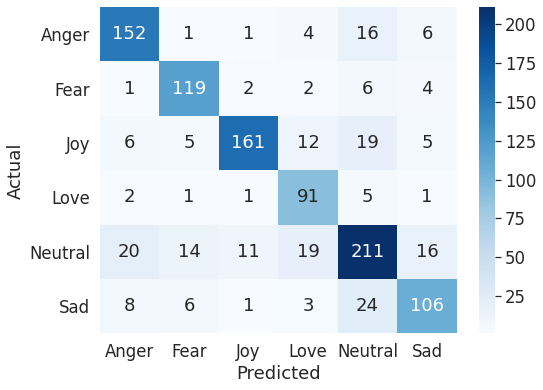

Training finished!


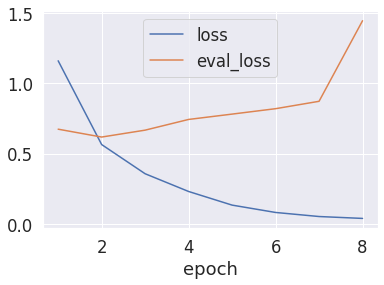

Total time: 5.338036366303762 minutes


In [11]:
#1 IndoBERTweet

main(
    model_name = 'indolem/indobertweet-base-uncased',
    output_dir = 'emotcls-indobertweet-base',
    best_params = 'best_params/indobertweet.json'
)

{'num_train_epochs': 8, 'learning_rate': 3e-05, 'per_device_train_batch_size': 8, 'per_device_eval_batch_size': 16, 'weight_decay': 0.0538653814961811}


loading configuration file config.json from cache at /home/jupyter-145230403/.cache/huggingface/hub/models--FacebookAI--xlm-roberta-large/snapshots/c23d21b0620b635a76227c604d44e43a9f0ee389/config.json
Model config XLMRobertaConfig {
  "_name_or_path": "FacebookAI/xlm-roberta-large",
  "architectures": [
    "XLMRobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "id2label": {
    "0": "Anger",
    "1": "Fear",
    "2": "Joy",
    "3": "Love",
    "4": "Neutral",
    "5": "Sad"
  },
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "label2id": {
    "Anger": 0,
    "Fear": 1,
    "Joy": 2,
    "Love": 3,
    "Neutral": 4,
    "Sad": 5
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "xlm-roberta",
  "num_attention_heads": 16,
  "num_hidden_layers": 24,
  "output_past": true,
  "pad_to

  0%|          | 0/5 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the training set don't have a corresponding argument in `XLMRobertaForSequenceClassification.forward` and have been ignored: tweet, index. If tweet, index are not expected by `XLMRobertaForSequenceClassification.forward`,  you can safely ignore this message.
/home/jupyter-145230403/.conda/envs/conda_env_2/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 4956
  Num Epochs = 8
  Insta

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.693500,1.458202,0.463277,0.538416,0.484458,0.429113
2,1.020200,0.775992,0.728814,0.746253,0.742878,0.738007
3,0.665200,0.717062,0.748588,0.755696,0.776843,0.757495
4,0.495100,0.655568,0.778719,0.785372,0.792292,0.785641
5,0.382400,0.699042,0.774011,0.779839,0.783729,0.780065
6,0.287700,0.760836,0.774953,0.791037,0.776158,0.781329
7,0.177400,0.851166,0.781544,0.780114,0.795755,0.785907
8,0.132200,0.866531,0.788136,0.788134,0.798554,0.792683


The following columns in the evaluation set don't have a corresponding argument in `XLMRobertaForSequenceClassification.forward` and have been ignored: tweet, index. If tweet, index are not expected by `XLMRobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1062
  Batch size = 64


Classification Report:
              precision    recall  f1-score   support

       Anger     0.4118    0.4773    0.4421       176
        Fear     0.9167    0.0748    0.1384       147
         Joy     0.4545    0.5932    0.5147       177
        Love     0.4055    0.8957    0.5583       115
     Neutral     0.6522    0.4027    0.4979       298
         Sad     0.3898    0.4631    0.4233       149

    accuracy                         0.4633      1062
   macro avg     0.5384    0.4845    0.4291      1062
weighted avg     0.5525    0.4633    0.4378      1062



Saving model checkpoint to emotcls-xlm-r-large/checkpoint-155
Configuration saved in emotcls-xlm-r-large/checkpoint-155/config.json
Model weights saved in emotcls-xlm-r-large/checkpoint-155/pytorch_model.bin
tokenizer config file saved in emotcls-xlm-r-large/checkpoint-155/tokenizer_config.json
Special tokens file saved in emotcls-xlm-r-large/checkpoint-155/special_tokens_map.json
Deleting older checkpoint [emotcls-xlm-r-large/checkpoint-620] due to args.save_total_limit
/home/jupyter-145230403/.conda/envs/conda_env_2/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
The following columns in the evaluation set don't have a corresponding argument in `XLMRobertaForSequenceClassification.forward` and have been ignored: tweet, index. If tweet, index are not expected by `XLMRobertaF

Classification Report:
              precision    recall  f1-score   support

       Anger     0.7818    0.7330    0.7566       176
        Fear     0.8400    0.7143    0.7721       147
         Joy     0.7885    0.6949    0.7387       177
        Love     0.6023    0.8957    0.7203       115
     Neutral     0.6634    0.6879    0.6755       298
         Sad     0.8015    0.7315    0.7649       149

    accuracy                         0.7288      1062
   macro avg     0.7463    0.7429    0.7380      1062
weighted avg     0.7411    0.7288    0.7302      1062



Saving model checkpoint to emotcls-xlm-r-large/checkpoint-310
Configuration saved in emotcls-xlm-r-large/checkpoint-310/config.json
Model weights saved in emotcls-xlm-r-large/checkpoint-310/pytorch_model.bin
tokenizer config file saved in emotcls-xlm-r-large/checkpoint-310/tokenizer_config.json
Special tokens file saved in emotcls-xlm-r-large/checkpoint-310/special_tokens_map.json
Deleting older checkpoint [emotcls-xlm-r-large/checkpoint-155] due to args.save_total_limit
/home/jupyter-145230403/.conda/envs/conda_env_2/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
The following columns in the evaluation set don't have a corresponding argument in `XLMRobertaForSequenceClassification.forward` and have been ignored: tweet, index. If tweet, index are not expected by `XLMRobertaF

Classification Report:
              precision    recall  f1-score   support

       Anger     0.6978    0.8920    0.7830       176
        Fear     0.8692    0.7687    0.8159       147
         Joy     0.7679    0.7288    0.7478       177
        Love     0.6205    0.8957    0.7331       115
     Neutral     0.7719    0.5906    0.6692       298
         Sad     0.8069    0.7852    0.7959       149

    accuracy                         0.7486      1062
   macro avg     0.7557    0.7768    0.7575      1062
weighted avg     0.7609    0.7486    0.7462      1062



Saving model checkpoint to emotcls-xlm-r-large/checkpoint-465
Configuration saved in emotcls-xlm-r-large/checkpoint-465/config.json
Model weights saved in emotcls-xlm-r-large/checkpoint-465/pytorch_model.bin
tokenizer config file saved in emotcls-xlm-r-large/checkpoint-465/tokenizer_config.json
Special tokens file saved in emotcls-xlm-r-large/checkpoint-465/special_tokens_map.json
Deleting older checkpoint [emotcls-xlm-r-large/checkpoint-310] due to args.save_total_limit
/home/jupyter-145230403/.conda/envs/conda_env_2/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
The following columns in the evaluation set don't have a corresponding argument in `XLMRobertaForSequenceClassification.forward` and have been ignored: tweet, index. If tweet, index are not expected by `XLMRobertaF

Classification Report:
              precision    recall  f1-score   support

       Anger     0.7576    0.8523    0.8021       176
        Fear     0.8806    0.8027    0.8399       147
         Joy     0.7474    0.8023    0.7738       177
        Love     0.6879    0.8435    0.7578       115
     Neutral     0.7695    0.6946    0.7302       298
         Sad     0.8692    0.7584    0.8100       149

    accuracy                         0.7787      1062
   macro avg     0.7854    0.7923    0.7856      1062
weighted avg     0.7844    0.7787    0.7788      1062



Saving model checkpoint to emotcls-xlm-r-large/checkpoint-620
Configuration saved in emotcls-xlm-r-large/checkpoint-620/config.json
Model weights saved in emotcls-xlm-r-large/checkpoint-620/pytorch_model.bin
tokenizer config file saved in emotcls-xlm-r-large/checkpoint-620/tokenizer_config.json
Special tokens file saved in emotcls-xlm-r-large/checkpoint-620/special_tokens_map.json
Deleting older checkpoint [emotcls-xlm-r-large/checkpoint-465] due to args.save_total_limit
/home/jupyter-145230403/.conda/envs/conda_env_2/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
The following columns in the evaluation set don't have a corresponding argument in `XLMRobertaForSequenceClassification.forward` and have been ignored: tweet, index. If tweet, index are not expected by `XLMRobertaF

Classification Report:
              precision    recall  f1-score   support

       Anger     0.8046    0.7955    0.8000       176
        Fear     0.9015    0.8095    0.8530       147
         Joy     0.7059    0.8136    0.7559       177
        Love     0.7231    0.8174    0.7673       115
     Neutral     0.7662    0.7148    0.7396       298
         Sad     0.7778    0.7517    0.7645       149

    accuracy                         0.7740      1062
   macro avg     0.7798    0.7837    0.7801      1062
weighted avg     0.7782    0.7740    0.7745      1062



Saving model checkpoint to emotcls-xlm-r-large/checkpoint-775
Configuration saved in emotcls-xlm-r-large/checkpoint-775/config.json
Model weights saved in emotcls-xlm-r-large/checkpoint-775/pytorch_model.bin
tokenizer config file saved in emotcls-xlm-r-large/checkpoint-775/tokenizer_config.json
Special tokens file saved in emotcls-xlm-r-large/checkpoint-775/special_tokens_map.json
/home/jupyter-145230403/.conda/envs/conda_env_2/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
The following columns in the evaluation set don't have a corresponding argument in `XLMRobertaForSequenceClassification.forward` and have been ignored: tweet, index. If tweet, index are not expected by `XLMRobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evalua

Classification Report:
              precision    recall  f1-score   support

       Anger     0.8187    0.7443    0.7798       176
        Fear     0.8824    0.8163    0.8481       147
         Joy     0.7609    0.7910    0.7756       177
        Love     0.7209    0.8087    0.7623       115
     Neutral     0.7073    0.7785    0.7412       298
         Sad     0.8560    0.7181    0.7810       149

    accuracy                         0.7750      1062
   macro avg     0.7910    0.7762    0.7813      1062
weighted avg     0.7813    0.7750    0.7760      1062



Saving model checkpoint to emotcls-xlm-r-large/checkpoint-930
Configuration saved in emotcls-xlm-r-large/checkpoint-930/config.json
Model weights saved in emotcls-xlm-r-large/checkpoint-930/pytorch_model.bin
tokenizer config file saved in emotcls-xlm-r-large/checkpoint-930/tokenizer_config.json
Special tokens file saved in emotcls-xlm-r-large/checkpoint-930/special_tokens_map.json
Deleting older checkpoint [emotcls-xlm-r-large/checkpoint-775] due to args.save_total_limit
/home/jupyter-145230403/.conda/envs/conda_env_2/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
The following columns in the evaluation set don't have a corresponding argument in `XLMRobertaForSequenceClassification.forward` and have been ignored: tweet, index. If tweet, index are not expected by `XLMRobertaF

Classification Report:
              precision    recall  f1-score   support

       Anger     0.7841    0.7841    0.7841       176
        Fear     0.8681    0.8503    0.8591       147
         Joy     0.7513    0.8192    0.7838       177
        Love     0.7355    0.7739    0.7542       115
     Neutral     0.8103    0.6879    0.7441       298
         Sad     0.7314    0.8591    0.7901       149

    accuracy                         0.7815      1062
   macro avg     0.7801    0.7958    0.7859      1062
weighted avg     0.7849    0.7815    0.7808      1062



Saving model checkpoint to emotcls-xlm-r-large/checkpoint-1085
Configuration saved in emotcls-xlm-r-large/checkpoint-1085/config.json
Model weights saved in emotcls-xlm-r-large/checkpoint-1085/pytorch_model.bin
tokenizer config file saved in emotcls-xlm-r-large/checkpoint-1085/tokenizer_config.json
Special tokens file saved in emotcls-xlm-r-large/checkpoint-1085/special_tokens_map.json
Deleting older checkpoint [emotcls-xlm-r-large/checkpoint-930] due to args.save_total_limit
/home/jupyter-145230403/.conda/envs/conda_env_2/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
The following columns in the evaluation set don't have a corresponding argument in `XLMRobertaForSequenceClassification.forward` and have been ignored: tweet, index. If tweet, index are not expected by `XLMRob

Classification Report:
              precision    recall  f1-score   support

       Anger     0.7790    0.8011    0.7899       176
        Fear     0.8431    0.8776    0.8600       147
         Joy     0.7688    0.8079    0.7879       177
        Love     0.7280    0.7913    0.7583       115
     Neutral     0.7847    0.7215    0.7517       298
         Sad     0.8252    0.7919    0.8082       149

    accuracy                         0.7881      1062
   macro avg     0.7881    0.7986    0.7927      1062
weighted avg     0.7887    0.7881    0.7877      1062



Saving model checkpoint to emotcls-xlm-r-large/checkpoint-1240
Configuration saved in emotcls-xlm-r-large/checkpoint-1240/config.json
Model weights saved in emotcls-xlm-r-large/checkpoint-1240/pytorch_model.bin
tokenizer config file saved in emotcls-xlm-r-large/checkpoint-1240/tokenizer_config.json
Special tokens file saved in emotcls-xlm-r-large/checkpoint-1240/special_tokens_map.json
Deleting older checkpoint [emotcls-xlm-r-large/checkpoint-1085] due to args.save_total_limit


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from emotcls-xlm-r-large/checkpoint-620 (score: 0.6555681824684143).
Deleting older checkpoint [emotcls-xlm-r-large/checkpoint-1240] due to args.save_total_limit
Saving model checkpoint to emotcls-xlm-r-large
Configuration saved in emotcls-xlm-r-large/config.json
Model weights saved in emotcls-xlm-r-large/pytorch_model.bin
tokenizer config file saved in emotcls-xlm-r-large/tokenizer_config.json
Special tokens 

The following columns in the test set don't have a corresponding argument in `XLMRobertaForSequenceClassification.forward` and have been ignored: tweet, index. If tweet, index are not expected by `XLMRobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 1062
  Batch size = 64


Classification Report:
              precision    recall  f1-score   support

       Anger     0.7720    0.8278    0.7989       180
        Fear     0.8485    0.8358    0.8421       134
         Joy     0.8294    0.8413    0.8353       208
        Love     0.7097    0.8713    0.7822       101
     Neutral     0.7576    0.6873    0.7207       291
         Sad     0.8188    0.7635    0.7902       148

    accuracy                         0.7881      1062
   macro avg     0.7893    0.8045    0.7949      1062
weighted avg     0.7895    0.7881    0.7873      1062

{'eval_loss': 0.6203622817993164, 'eval_accuracy': 0.788135593220339, 'eval_precision': 0.7893305361283525, 'eval_recall': 0.8045051154567336, 'eval_f1': 0.7949179676592838, 'eval_runtime': 9.3372, 'eval_samples_per_second': 113.739, 'eval_steps_per_second': 1.821, 'epoch': 8.0}


/home/jupyter-145230403/.conda/envs/conda_env_2/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Classification Report:
              precision    recall  f1-score   support

       Anger     0.7720    0.8278    0.7989       180
        Fear     0.8485    0.8358    0.8421       134
         Joy     0.8294    0.8413    0.8353       208
        Love     0.7097    0.8713    0.7822       101
     Neutral     0.7576    0.6873    0.7207       291
         Sad     0.8188    0.7635    0.7902       148

    accuracy                         0.7881      1062
   macro avg     0.7893    0.8045    0.7949      1062
weighted avg     0.7895    0.7881    0.7873      1062



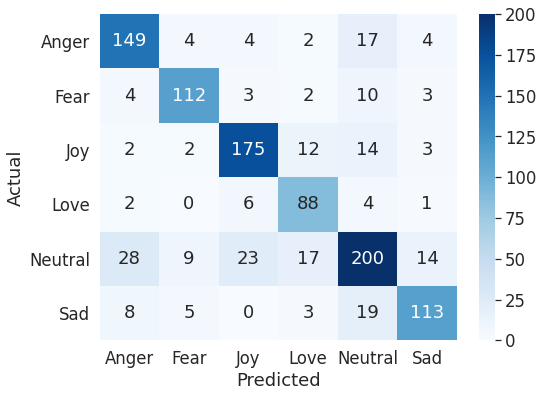

Training finished!


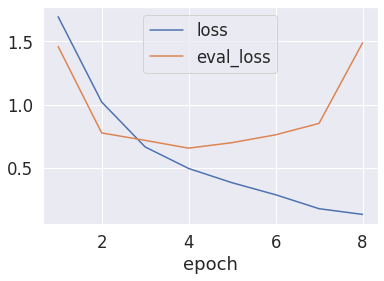

Total time: 22.312350459893544 minutes


In [13]:
#2 FacebookAI/xlm-roberta-large

main(
    model_name = 'FacebookAI/xlm-roberta-large',
    output_dir = 'emotcls-xlm-r-large',
    best_params = 'best_params/xlm-r-large.json'
)

{'num_train_epochs': 6, 'learning_rate': 5e-05, 'per_device_train_batch_size': 16, 'per_device_eval_batch_size': 8, 'weight_decay': 0.03202288065105585}


loading configuration file config.json from cache at /home/jupyter-145230403/.cache/huggingface/hub/models--FacebookAI--xlm-roberta-base/snapshots/e73636d4f797dec63c3081bb6ed5c7b0bb3f2089/config.json
Model config XLMRobertaConfig {
  "_name_or_path": "FacebookAI/xlm-roberta-base",
  "architectures": [
    "XLMRobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "Anger",
    "1": "Fear",
    "2": "Joy",
    "3": "Love",
    "4": "Neutral",
    "5": "Sad"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "Anger": 0,
    "Fear": 1,
    "Joy": 2,
    "Love": 3,
    "Neutral": 4,
    "Sad": 5
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "xlm-roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token

  0%|          | 0/5 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the training set don't have a corresponding argument in `XLMRobertaForSequenceClassification.forward` and have been ignored: tweet, index. If tweet, index are not expected by `XLMRobertaForSequenceClassification.forward`,  you can safely ignore this message.
/home/jupyter-145230403/.conda/envs/conda_env_2/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 4956
  Num Epochs = 6
  Insta

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.321600,0.805724,0.717514,0.724186,0.738374,0.726367
2,0.726200,0.816596,0.727872,0.733943,0.767569,0.737622
3,0.561000,0.740903,0.751412,0.756408,0.773339,0.758374
4,0.436800,0.761752,0.747646,0.760119,0.763192,0.754314
5,0.340900,0.805529,0.750471,0.752257,0.773450,0.758300
6,0.262800,0.786088,0.773070,0.775448,0.791609,0.781120


The following columns in the evaluation set don't have a corresponding argument in `XLMRobertaForSequenceClassification.forward` and have been ignored: tweet, index. If tweet, index are not expected by `XLMRobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1062
  Batch size = 32


Classification Report:
              precision    recall  f1-score   support

       Anger     0.6483    0.8693    0.7427       176
        Fear     0.7838    0.7891    0.7864       147
         Joy     0.6963    0.7514    0.7228       177
        Love     0.7345    0.7217    0.7281       115
     Neutral     0.7389    0.5604    0.6374       298
         Sad     0.7432    0.7383    0.7407       149

    accuracy                         0.7175      1062
   macro avg     0.7242    0.7384    0.7264      1062
weighted avg     0.7231    0.7175    0.7140      1062



Saving model checkpoint to emotcls-xlm-r-base/checkpoint-78
Configuration saved in emotcls-xlm-r-base/checkpoint-78/config.json
Model weights saved in emotcls-xlm-r-base/checkpoint-78/pytorch_model.bin
tokenizer config file saved in emotcls-xlm-r-base/checkpoint-78/tokenizer_config.json
Special tokens file saved in emotcls-xlm-r-base/checkpoint-78/special_tokens_map.json
/home/jupyter-145230403/.conda/envs/conda_env_2/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
The following columns in the evaluation set don't have a corresponding argument in `XLMRobertaForSequenceClassification.forward` and have been ignored: tweet, index. If tweet, index are not expected by `XLMRobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****

Classification Report:
              precision    recall  f1-score   support

       Anger     0.6681    0.8920    0.7640       176
        Fear     0.8309    0.7687    0.7986       147
         Joy     0.7128    0.7571    0.7342       177
        Love     0.6358    0.8957    0.7437       115
     Neutral     0.8077    0.4933    0.6125       298
         Sad     0.7484    0.7987    0.7727       149

    accuracy                         0.7279      1062
   macro avg     0.7339    0.7676    0.7376      1062
weighted avg     0.7450    0.7279    0.7203      1062



Saving model checkpoint to emotcls-xlm-r-base/checkpoint-156
Configuration saved in emotcls-xlm-r-base/checkpoint-156/config.json
Model weights saved in emotcls-xlm-r-base/checkpoint-156/pytorch_model.bin
tokenizer config file saved in emotcls-xlm-r-base/checkpoint-156/tokenizer_config.json
Special tokens file saved in emotcls-xlm-r-base/checkpoint-156/special_tokens_map.json
/home/jupyter-145230403/.conda/envs/conda_env_2/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
The following columns in the evaluation set don't have a corresponding argument in `XLMRobertaForSequenceClassification.forward` and have been ignored: tweet, index. If tweet, index are not expected by `XLMRobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation 

Classification Report:
              precision    recall  f1-score   support

       Anger     0.7988    0.7670    0.7826       176
        Fear     0.8571    0.7755    0.8143       147
         Joy     0.7529    0.7401    0.7464       177
        Love     0.5909    0.9043    0.7148       115
     Neutral     0.7558    0.6544    0.7014       298
         Sad     0.7829    0.7987    0.7907       149

    accuracy                         0.7514      1062
   macro avg     0.7564    0.7733    0.7584      1062
weighted avg     0.7624    0.7514    0.7520      1062



Saving model checkpoint to emotcls-xlm-r-base/checkpoint-234
Configuration saved in emotcls-xlm-r-base/checkpoint-234/config.json
Model weights saved in emotcls-xlm-r-base/checkpoint-234/pytorch_model.bin
tokenizer config file saved in emotcls-xlm-r-base/checkpoint-234/tokenizer_config.json
Special tokens file saved in emotcls-xlm-r-base/checkpoint-234/special_tokens_map.json
Deleting older checkpoint [emotcls-xlm-r-base/checkpoint-78] due to args.save_total_limit
Deleting older checkpoint [emotcls-xlm-r-base/checkpoint-156] due to args.save_total_limit
/home/jupyter-145230403/.conda/envs/conda_env_2/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
The following columns in the evaluation set don't have a corresponding argument in `XLMRobertaForSequenceClassification.forward` a

Classification Report:
              precision    recall  f1-score   support

       Anger     0.6881    0.8523    0.7614       176
        Fear     0.8682    0.7619    0.8116       147
         Joy     0.7128    0.7853    0.7473       177
        Love     0.6644    0.8609    0.7500       115
     Neutral     0.7588    0.6544    0.7027       298
         Sad     0.8684    0.6644    0.7529       149

    accuracy                         0.7476      1062
   macro avg     0.7601    0.7632    0.7543      1062
weighted avg     0.7597    0.7476    0.7471      1062



Saving model checkpoint to emotcls-xlm-r-base/checkpoint-312
Configuration saved in emotcls-xlm-r-base/checkpoint-312/config.json
Model weights saved in emotcls-xlm-r-base/checkpoint-312/pytorch_model.bin
tokenizer config file saved in emotcls-xlm-r-base/checkpoint-312/tokenizer_config.json
Special tokens file saved in emotcls-xlm-r-base/checkpoint-312/special_tokens_map.json
/home/jupyter-145230403/.conda/envs/conda_env_2/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
The following columns in the evaluation set don't have a corresponding argument in `XLMRobertaForSequenceClassification.forward` and have been ignored: tweet, index. If tweet, index are not expected by `XLMRobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation 

Classification Report:
              precision    recall  f1-score   support

       Anger     0.7540    0.8011    0.7769       176
        Fear     0.8582    0.7823    0.8185       147
         Joy     0.7340    0.7797    0.7562       177
        Love     0.6474    0.8783    0.7454       115
     Neutral     0.7633    0.6275    0.6888       298
         Sad     0.7566    0.7718    0.7641       149

    accuracy                         0.7505      1062
   macro avg     0.7523    0.7735    0.7583      1062
weighted avg     0.7565    0.7505    0.7493      1062



Saving model checkpoint to emotcls-xlm-r-base/checkpoint-390
Configuration saved in emotcls-xlm-r-base/checkpoint-390/config.json
Model weights saved in emotcls-xlm-r-base/checkpoint-390/pytorch_model.bin
tokenizer config file saved in emotcls-xlm-r-base/checkpoint-390/tokenizer_config.json
Special tokens file saved in emotcls-xlm-r-base/checkpoint-390/special_tokens_map.json
Deleting older checkpoint [emotcls-xlm-r-base/checkpoint-312] due to args.save_total_limit
/home/jupyter-145230403/.conda/envs/conda_env_2/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
The following columns in the evaluation set don't have a corresponding argument in `XLMRobertaForSequenceClassification.forward` and have been ignored: tweet, index. If tweet, index are not expected by `XLMRobertaForSequ

Classification Report:
              precision    recall  f1-score   support

       Anger     0.7513    0.8239    0.7859       176
        Fear     0.8552    0.8435    0.8493       147
         Joy     0.7640    0.7684    0.7662       177
        Love     0.6923    0.8609    0.7674       115
     Neutral     0.7672    0.6745    0.7179       298
         Sad     0.8227    0.7785    0.8000       149

    accuracy                         0.7731      1062
   macro avg     0.7754    0.7916    0.7811      1062
weighted avg     0.7759    0.7731    0.7723      1062



Saving model checkpoint to emotcls-xlm-r-base/checkpoint-468
Configuration saved in emotcls-xlm-r-base/checkpoint-468/config.json
Model weights saved in emotcls-xlm-r-base/checkpoint-468/pytorch_model.bin
tokenizer config file saved in emotcls-xlm-r-base/checkpoint-468/tokenizer_config.json
Special tokens file saved in emotcls-xlm-r-base/checkpoint-468/special_tokens_map.json
Deleting older checkpoint [emotcls-xlm-r-base/checkpoint-390] due to args.save_total_limit


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from emotcls-xlm-r-base/checkpoint-234 (score: 0.7409029603004456).
Deleting older checkpoint [emotcls-xlm-r-base/checkpoint-468] due to args.save_total_limit
Saving model checkpoint to emotcls-xlm-r-base
Configuration saved in emotcls-xlm-r-base/config.json
Model weights saved in emotcls-xlm-r-base/pytorch_model.bin
tokenizer config file saved in emotcls-xlm-r-base/tokenizer_config.json
Special tokens file saved in emotc

The following columns in the test set don't have a corresponding argument in `XLMRobertaForSequenceClassification.forward` and have been ignored: tweet, index. If tweet, index are not expected by `XLMRobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 1062
  Batch size = 32


Classification Report:
              precision    recall  f1-score   support

       Anger     0.8250    0.7333    0.7765       180
        Fear     0.8209    0.8209    0.8209       134
         Joy     0.8316    0.7837    0.8069       208
        Love     0.5796    0.9010    0.7054       101
     Neutral     0.7610    0.6564    0.7048       291
         Sad     0.7195    0.7973    0.7564       148

    accuracy                         0.7580      1062
   macro avg     0.7563    0.7821    0.7618      1062
weighted avg     0.7702    0.7580    0.7589      1062

{'eval_loss': 0.7084178924560547, 'eval_accuracy': 0.7580037664783428, 'eval_precision': 0.7562690633774909, 'eval_recall': 0.7820879144164313, 'eval_f1': 0.7618217441104239, 'eval_runtime': 9.0043, 'eval_samples_per_second': 117.943, 'eval_steps_per_second': 3.776, 'epoch': 6.0}


/home/jupyter-145230403/.conda/envs/conda_env_2/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Classification Report:
              precision    recall  f1-score   support

       Anger     0.8250    0.7333    0.7765       180
        Fear     0.8209    0.8209    0.8209       134
         Joy     0.8316    0.7837    0.8069       208
        Love     0.5796    0.9010    0.7054       101
     Neutral     0.7610    0.6564    0.7048       291
         Sad     0.7195    0.7973    0.7564       148

    accuracy                         0.7580      1062
   macro avg     0.7563    0.7821    0.7618      1062
weighted avg     0.7702    0.7580    0.7589      1062



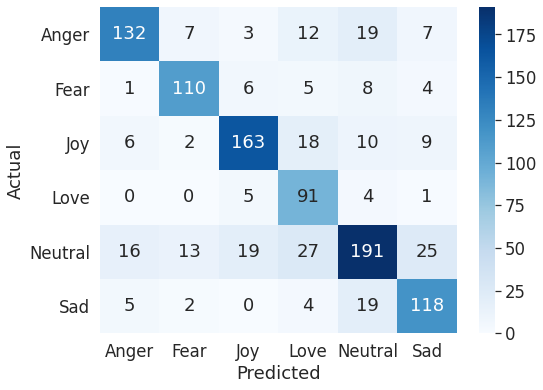

Training finished!


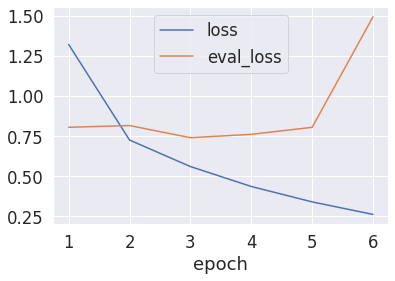

Total time: 6.558300805091858 minutes


In [14]:
#3 FacebookAI/xlm-roberta-base

main(
    model_name = 'FacebookAI/xlm-roberta-base',
    output_dir = 'emotcls-xlm-r-base',
    best_params = 'best_params/xlm-r-base.json'
)

{'num_train_epochs': 9, 'learning_rate': 5e-05, 'per_device_train_batch_size': 16, 'per_device_eval_batch_size': 64, 'weight_decay': 0.007705240615613307}


loading configuration file config.json from cache at /home/jupyter-145230403/.cache/huggingface/hub/models--google-bert--bert-base-multilingual-cased/snapshots/3f076fdb1ab68d5b2880cb87a0886f315b8146f8/config.json
Model config BertConfig {
  "_name_or_path": "google-bert/bert-base-multilingual-cased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "Anger",
    "1": "Fear",
    "2": "Joy",
    "3": "Love",
    "4": "Neutral",
    "5": "Sad"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "Anger": 0,
    "Fear": 1,
    "Joy": 2,
    "Love": 3,
    "Neutral": 4,
    "Sad": 5
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 7

  0%|          | 0/5 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: tweet, index. If tweet, index are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/home/jupyter-145230403/.conda/envs/conda_env_2/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 4956
  Num Epochs = 9
  Instantaneous bat

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.401900,0.957394,0.673258,0.677400,0.688485,0.679899
2,0.851900,0.809642,0.719397,0.717916,0.749779,0.725644
3,0.656500,0.852941,0.724105,0.754996,0.734563,0.731370
4,0.500000,0.848595,0.722222,0.737707,0.741964,0.733671
5,0.356400,0.942655,0.724105,0.727803,0.741267,0.730756
6,0.237600,0.956153,0.738230,0.746351,0.751289,0.748377
7,0.170700,1.031108,0.730697,0.732583,0.750789,0.739939
8,0.107400,1.068391,0.741996,0.746854,0.755390,0.750190
9,0.074500,1.109393,0.727872,0.736003,0.739804,0.737408


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: tweet, index. If tweet, index are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1062
  Batch size = 256


Classification Report:
              precision    recall  f1-score   support

       Anger     0.6464    0.6648    0.6555       176
        Fear     0.6962    0.7483    0.7213       147
         Joy     0.7708    0.6271    0.6916       177
        Love     0.6069    0.7652    0.6769       115
     Neutral     0.6512    0.6141    0.6321       298
         Sad     0.6928    0.7114    0.7020       149

    accuracy                         0.6733      1062
   macro avg     0.6774    0.6885    0.6799      1062
weighted avg     0.6776    0.6733    0.6729      1062



Saving model checkpoint to emotcls-bert-base/checkpoint-78
Configuration saved in emotcls-bert-base/checkpoint-78/config.json
Model weights saved in emotcls-bert-base/checkpoint-78/pytorch_model.bin
tokenizer config file saved in emotcls-bert-base/checkpoint-78/tokenizer_config.json
Special tokens file saved in emotcls-bert-base/checkpoint-78/special_tokens_map.json
/home/jupyter-145230403/.conda/envs/conda_env_2/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: tweet, index. If tweet, index are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples =

Classification Report:
              precision    recall  f1-score   support

       Anger     0.6976    0.8125    0.7507       176
        Fear     0.7593    0.8367    0.7961       147
         Joy     0.7056    0.7175    0.7115       177
        Love     0.6220    0.8870    0.7312       115
     Neutral     0.7840    0.5604    0.6536       298
         Sad     0.7391    0.6846    0.7108       149

    accuracy                         0.7194      1062
   macro avg     0.7179    0.7498    0.7256      1062
weighted avg     0.7293    0.7194    0.7155      1062



Saving model checkpoint to emotcls-bert-base/checkpoint-156
Configuration saved in emotcls-bert-base/checkpoint-156/config.json
Model weights saved in emotcls-bert-base/checkpoint-156/pytorch_model.bin
tokenizer config file saved in emotcls-bert-base/checkpoint-156/tokenizer_config.json
Special tokens file saved in emotcls-bert-base/checkpoint-156/special_tokens_map.json
Deleting older checkpoint [emotcls-bert-base/checkpoint-78] due to args.save_total_limit
/home/jupyter-145230403/.conda/envs/conda_env_2/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: tweet, index. If tweet, index are not expected by `BertForSequenceClassification.

Classification Report:
              precision    recall  f1-score   support

       Anger     0.8322    0.7045    0.7631       176
        Fear     0.8682    0.7619    0.8116       147
         Joy     0.7756    0.6836    0.7267       177
        Love     0.5436    0.9217    0.6839       115
     Neutral     0.6585    0.7181    0.6870       298
         Sad     0.8519    0.6174    0.7160       149

    accuracy                         0.7241      1062
   macro avg     0.7550    0.7346    0.7314      1062
weighted avg     0.7505    0.7241    0.7272      1062



Saving model checkpoint to emotcls-bert-base/checkpoint-234
Configuration saved in emotcls-bert-base/checkpoint-234/config.json
Model weights saved in emotcls-bert-base/checkpoint-234/pytorch_model.bin
tokenizer config file saved in emotcls-bert-base/checkpoint-234/tokenizer_config.json
Special tokens file saved in emotcls-bert-base/checkpoint-234/special_tokens_map.json
/home/jupyter-145230403/.conda/envs/conda_env_2/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: tweet, index. If tweet, index are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examp

Classification Report:
              precision    recall  f1-score   support

       Anger     0.7287    0.7784    0.7527       176
        Fear     0.8571    0.7755    0.8143       147
         Joy     0.6104    0.7966    0.6912       177
        Love     0.6738    0.8261    0.7422       115
     Neutral     0.7229    0.6040    0.6581       298
         Sad     0.8333    0.6711    0.7435       149

    accuracy                         0.7222      1062
   macro avg     0.7377    0.7420    0.7337      1062
weighted avg     0.7339    0.7222    0.7220      1062



Saving model checkpoint to emotcls-bert-base/checkpoint-312
Configuration saved in emotcls-bert-base/checkpoint-312/config.json
Model weights saved in emotcls-bert-base/checkpoint-312/pytorch_model.bin
tokenizer config file saved in emotcls-bert-base/checkpoint-312/tokenizer_config.json
Special tokens file saved in emotcls-bert-base/checkpoint-312/special_tokens_map.json
Deleting older checkpoint [emotcls-bert-base/checkpoint-234] due to args.save_total_limit
/home/jupyter-145230403/.conda/envs/conda_env_2/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: tweet, index. If tweet, index are not expected by `BertForSequenceClassification

Classification Report:
              precision    recall  f1-score   support

       Anger     0.6637    0.8523    0.7463       176
        Fear     0.7500    0.8571    0.8000       147
         Joy     0.7593    0.6949    0.7257       177
        Love     0.7105    0.7043    0.7074       115
     Neutral     0.7247    0.6007    0.6569       298
         Sad     0.7586    0.7383    0.7483       149

    accuracy                         0.7241      1062
   macro avg     0.7278    0.7413    0.7308      1062
weighted avg     0.7271    0.7241    0.7213      1062



Saving model checkpoint to emotcls-bert-base/checkpoint-390
Configuration saved in emotcls-bert-base/checkpoint-390/config.json
Model weights saved in emotcls-bert-base/checkpoint-390/pytorch_model.bin
tokenizer config file saved in emotcls-bert-base/checkpoint-390/tokenizer_config.json
Special tokens file saved in emotcls-bert-base/checkpoint-390/special_tokens_map.json
Deleting older checkpoint [emotcls-bert-base/checkpoint-312] due to args.save_total_limit
/home/jupyter-145230403/.conda/envs/conda_env_2/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: tweet, index. If tweet, index are not expected by `BertForSequenceClassification

Classification Report:
              precision    recall  f1-score   support

       Anger     0.7543    0.7500    0.7521       176
        Fear     0.8243    0.8299    0.8271       147
         Joy     0.7278    0.6949    0.7110       177
        Love     0.7188    0.8000    0.7572       115
     Neutral     0.6858    0.6812    0.6835       298
         Sad     0.7671    0.7517    0.7593       149

    accuracy                         0.7382      1062
   macro avg     0.7464    0.7513    0.7484      1062
weighted avg     0.7383    0.7382    0.7380      1062



Saving model checkpoint to emotcls-bert-base/checkpoint-468
Configuration saved in emotcls-bert-base/checkpoint-468/config.json
Model weights saved in emotcls-bert-base/checkpoint-468/pytorch_model.bin
tokenizer config file saved in emotcls-bert-base/checkpoint-468/tokenizer_config.json
Special tokens file saved in emotcls-bert-base/checkpoint-468/special_tokens_map.json
Deleting older checkpoint [emotcls-bert-base/checkpoint-390] due to args.save_total_limit
/home/jupyter-145230403/.conda/envs/conda_env_2/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: tweet, index. If tweet, index are not expected by `BertForSequenceClassification

Classification Report:
              precision    recall  f1-score   support

       Anger     0.7240    0.7898    0.7554       176
        Fear     0.8112    0.7891    0.8000       147
         Joy     0.7232    0.7232    0.7232       177
        Love     0.6917    0.8000    0.7419       115
     Neutral     0.7188    0.6174    0.6643       298
         Sad     0.7267    0.7852    0.7548       149

    accuracy                         0.7307      1062
   macro avg     0.7326    0.7508    0.7399      1062
weighted avg     0.7313    0.7307    0.7291      1062



Saving model checkpoint to emotcls-bert-base/checkpoint-546
Configuration saved in emotcls-bert-base/checkpoint-546/config.json
Model weights saved in emotcls-bert-base/checkpoint-546/pytorch_model.bin
tokenizer config file saved in emotcls-bert-base/checkpoint-546/tokenizer_config.json
Special tokens file saved in emotcls-bert-base/checkpoint-546/special_tokens_map.json
Deleting older checkpoint [emotcls-bert-base/checkpoint-468] due to args.save_total_limit
/home/jupyter-145230403/.conda/envs/conda_env_2/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: tweet, index. If tweet, index are not expected by `BertForSequenceClassification

Classification Report:
              precision    recall  f1-score   support

       Anger     0.7158    0.7727    0.7432       176
        Fear     0.8207    0.8095    0.8151       147
         Joy     0.7590    0.7119    0.7347       177
        Love     0.7099    0.8087    0.7561       115
     Neutral     0.7138    0.6779    0.6954       298
         Sad     0.7619    0.7517    0.7568       149

    accuracy                         0.7420      1062
   macro avg     0.7469    0.7554    0.7502      1062
weighted avg     0.7428    0.7420    0.7416      1062



Saving model checkpoint to emotcls-bert-base/checkpoint-624
Configuration saved in emotcls-bert-base/checkpoint-624/config.json
Model weights saved in emotcls-bert-base/checkpoint-624/pytorch_model.bin
tokenizer config file saved in emotcls-bert-base/checkpoint-624/tokenizer_config.json
Special tokens file saved in emotcls-bert-base/checkpoint-624/special_tokens_map.json
Deleting older checkpoint [emotcls-bert-base/checkpoint-546] due to args.save_total_limit
/home/jupyter-145230403/.conda/envs/conda_env_2/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: tweet, index. If tweet, index are not expected by `BertForSequenceClassification

Classification Report:
              precision    recall  f1-score   support

       Anger     0.7278    0.7443    0.7360       176
        Fear     0.8176    0.8231    0.8203       147
         Joy     0.7576    0.7062    0.7310       177
        Love     0.7087    0.7826    0.7438       115
     Neutral     0.6734    0.6711    0.6723       298
         Sad     0.7310    0.7114    0.7211       149

    accuracy                         0.7279      1062
   macro avg     0.7360    0.7398    0.7374      1062
weighted avg     0.7283    0.7279    0.7277      1062



Saving model checkpoint to emotcls-bert-base/checkpoint-702
Configuration saved in emotcls-bert-base/checkpoint-702/config.json
Model weights saved in emotcls-bert-base/checkpoint-702/pytorch_model.bin
tokenizer config file saved in emotcls-bert-base/checkpoint-702/tokenizer_config.json
Special tokens file saved in emotcls-bert-base/checkpoint-702/special_tokens_map.json
Deleting older checkpoint [emotcls-bert-base/checkpoint-624] due to args.save_total_limit


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from emotcls-bert-base/checkpoint-156 (score: 0.8096420168876648).
Deleting older checkpoint [emotcls-bert-base/checkpoint-702] due to args.save_total_limit
Saving model checkpoint to emotcls-bert-base
Configuration saved in emotcls-bert-base/config.json
Model weights saved in emotcls-bert-base/pytorch_model.bin
tokenizer config file saved in emotcls-bert-base/tokenizer_config.json
Special tokens file saved in emotcls-bert-base

The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: tweet, index. If tweet, index are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 1062
  Batch size = 256


Classification Report:
              precision    recall  f1-score   support

       Anger     0.7263    0.7667    0.7459       180
        Fear     0.7134    0.8731    0.7852       134
         Joy     0.7913    0.7837    0.7874       208
        Love     0.5935    0.9109    0.7187       101
     Neutral     0.7227    0.5464    0.6223       291
         Sad     0.7323    0.6284    0.6764       148

    accuracy                         0.7175      1062
   macro avg     0.7133    0.7515    0.7227      1062
weighted avg     0.7246    0.7175    0.7129      1062

{'eval_loss': 0.8138324618339539, 'eval_accuracy': 0.7175141242937854, 'eval_precision': 0.7132586139888885, 'eval_recall': 0.751519343540555, 'eval_f1': 0.7226738821361125, 'eval_runtime': 2.6481, 'eval_samples_per_second': 401.04, 'eval_steps_per_second': 1.888, 'epoch': 9.0}


/home/jupyter-145230403/.conda/envs/conda_env_2/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Classification Report:
              precision    recall  f1-score   support

       Anger     0.7263    0.7667    0.7459       180
        Fear     0.7134    0.8731    0.7852       134
         Joy     0.7913    0.7837    0.7874       208
        Love     0.5935    0.9109    0.7187       101
     Neutral     0.7227    0.5464    0.6223       291
         Sad     0.7323    0.6284    0.6764       148

    accuracy                         0.7175      1062
   macro avg     0.7133    0.7515    0.7227      1062
weighted avg     0.7246    0.7175    0.7129      1062



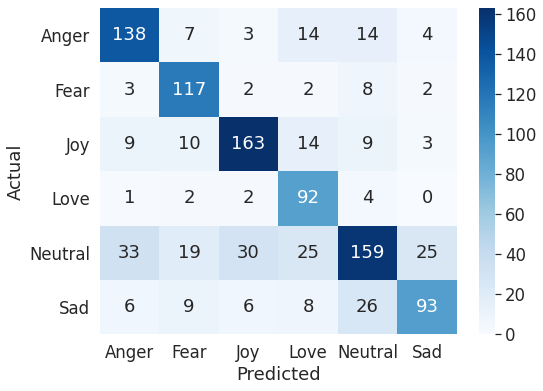

Training finished!


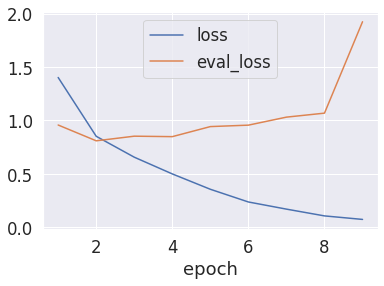

Total time: 7.058900272846222 minutes


In [15]:
#4 google-bert/bert-base-multilingual-cased

main(
    model_name = 'google-bert/bert-base-multilingual-cased',
    output_dir = 'emotcls-bert-base',
    best_params = 'best_params/mbert.json'
)